# Conversion Rate: A/B testing
This is a solution to a problem about A/B testing from the must have book on interview prep(A collection of Data Science Interviews). 

In [106]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pylab as pl
import statsmodels.api as sm
import sklearn as sk
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn.cross_validation import cross_val_score

plt.style.use('fivethirtyeight') #plot style used by fivethirtyeight
mpl.rcParams['figure.figsize'] = (12.0, 7.0)

In [39]:
data= pd.read_csv("/Users/oladipoositelu/Desktop/ecommerce.csv") 

Let's take a quick glance at the data 

In [40]:
data.head(3) #observe the first three rows of the data

,country,age,new_user,source,total_pages_visited,converted
0,UK,20,1,Direct,11,1
1,UK,37,1,Ads,15,1
2,UK,30,0,Seo,15,1


The dataset contains information on the country of a visitor, age, whether or not the visitor is new to the website, how the visitor came to find out about the website and the total pages visited. The target variable is whether or not the visitor converted(purchased something)

In [41]:
print "The shape of the data is:", data.shape

The shape of the data is: (20400, 6)


We have over 20,400 rows and 6 columns. Next, I would like to observe some summary statistics

In [42]:
data.describe()

,age,new_user,total_pages_visited,converted
count,20400.000000,20400.000000,20400.000000,20400.000000
mean,28.534804,0.499510,9.551569,0.500000
std,7.923346,0.500012,6.062382,0.500012
min,17.000000,0.000000,1.000000,0.000000
25%,22.000000,0.000000,4.000000,0.000000
50%,27.000000,0.000000,9.000000,0.500000
75%,34.000000,1.000000,15.000000,1.000000
max,123.000000,1.000000,30.000000,1.000000


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 6 columns):
country                20400 non-null object
age                    20400 non-null int64
new_user               20400 non-null int64
source                 20400 non-null object
total_pages_visited    20400 non-null int64
converted              20400 non-null int64
dtypes: int64(4), object(2)
memory usage: 956.3+ KB


Looking at the summary statistics. Something stands out immediately in the age statistic. The maximum age is 123. It seems to me that this is unlikely. Let's further investigate

In [44]:
 np.sort(data['age'].unique()) #check for unique ages and sort

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  71, 111, 123])

We notice that we have two ages that are over 100 (111 and 123 to be exact). These may errors, so I plan on dropping them from the sample. But first, I want to check how many values we have over 100.

In [45]:
len(data[data.age>100])

2

Now we know that we only have two occurences of the 20,400 observations that are over 100. Now I feel much better about dropping those rows. 

An interesting question is why do we have those ages? While it is not impossible to have customers that age, it is probably very unlikely. This could be a result of a problem with the website or customers putting bogus ages for whatever reason, accidental or on purpose.

In [46]:
data_1=data[data.age<100] # Only consider the ages less than 100

Before using any model, we can take a much closer look at the data to see what is going on.

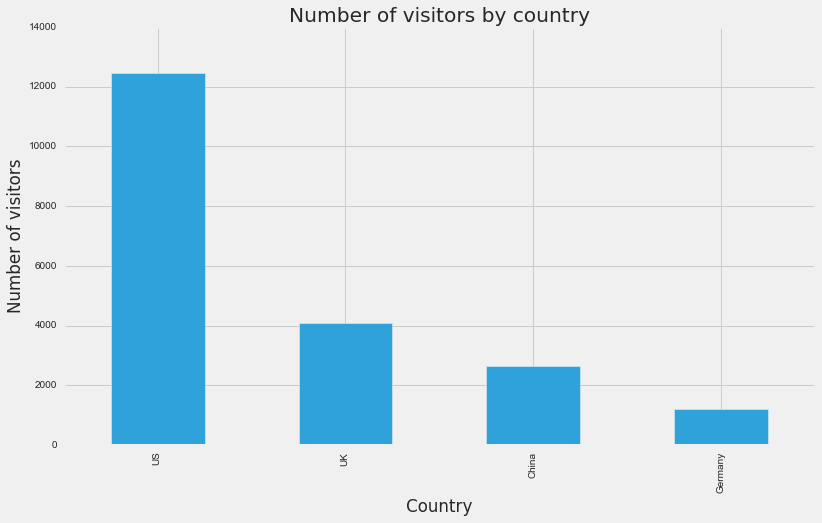

In [107]:
countries=data_1['country'].value_counts().plot(kind='bar')
plt.ylabel('Number of visitors')
plt.xlabel('Country')
plt.title('Number of visitors by country')

In [84]:
country=data_1['country'].value_counts()

In [124]:
#data_1.loc[:,'age_standardized']=(data_1['age']-data_1['age'].mean())/data_1['age'].std()

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


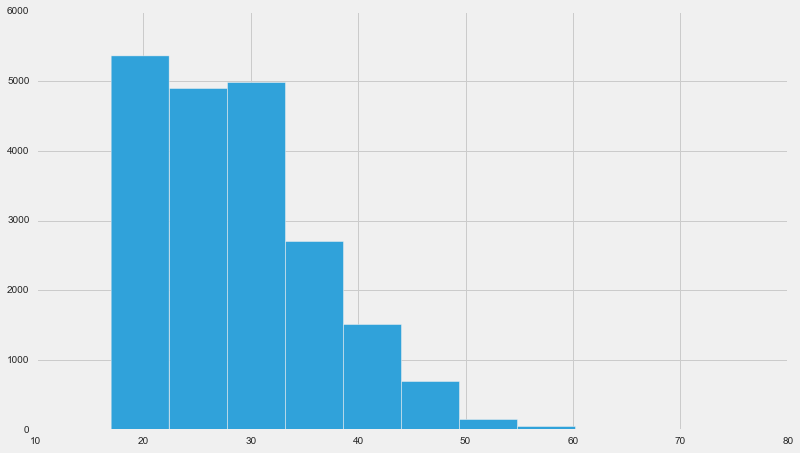

In [110]:
age=data_1['age'].hist()
maxi=np.argmax(data_1['age'])
#print maxi
age.set_alpha(2)

We can see that there are considerable more users in the USA than any of the other countries. This perhaps indicates that the website has its origins in the USA

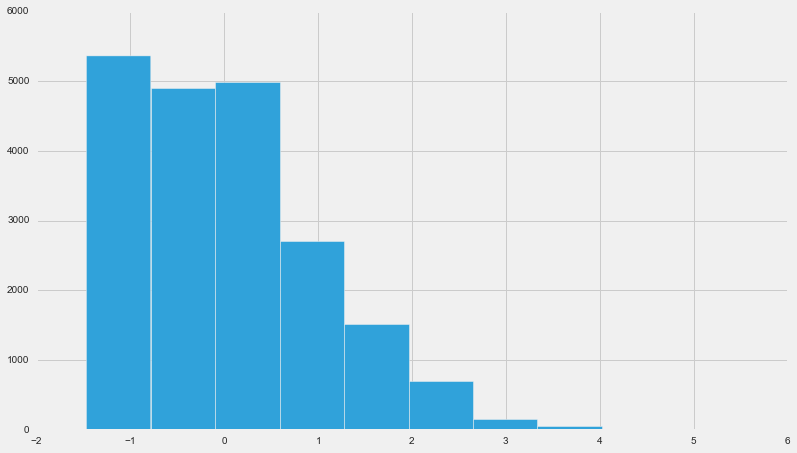

In [111]:
data_1.age_standardized.hist()

In [113]:
data_1[data_1.age_standardized>=2].shape

(754, 7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b0d4450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b6a38d0>]], dtype=object)

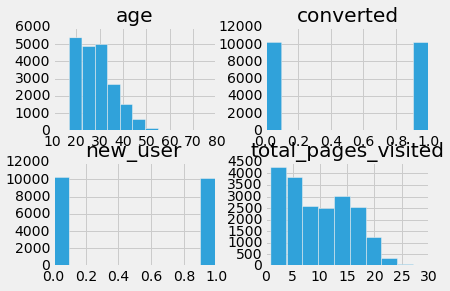

In [11]:
data_1.hist()

An interesting thing to look at is the conversion rate per country and age group

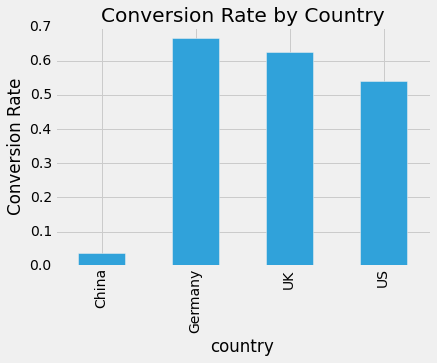

In [12]:
conversion_bycountry=data_1.groupby('country')
#conversion_bycountry.describe() #descriptive stats for the conversion rate per country

conversion_bycountry['converted'].aggregate(np.mean).plot(kind='bar')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Country')

China has a remarkably bad conversion rate while Germany has the best. This may indicate that there's a problem with the chinese website or that the product being sold is not highly valued or properly marketed in China. 

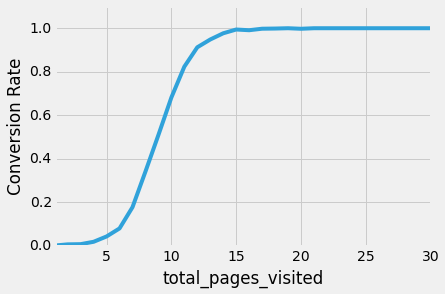

In [13]:
conversion_bypages=data_1['converted'].groupby(data_1['total_pages_visited'])
conversion_bypages.aggregate(np.mean).plot()
plt.ylim(0,1.1)
plt.ylabel('Conversion Rate')

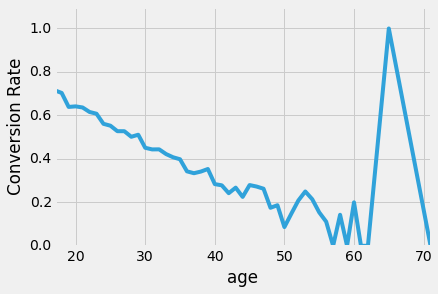

In [14]:
conversion_byage=data_1['converted'].groupby(data_1['age'])
conversion_byage.aggregate(np.mean).plot()
plt.ylim(0,1.1)
plt.ylabel('Conversion Rate')

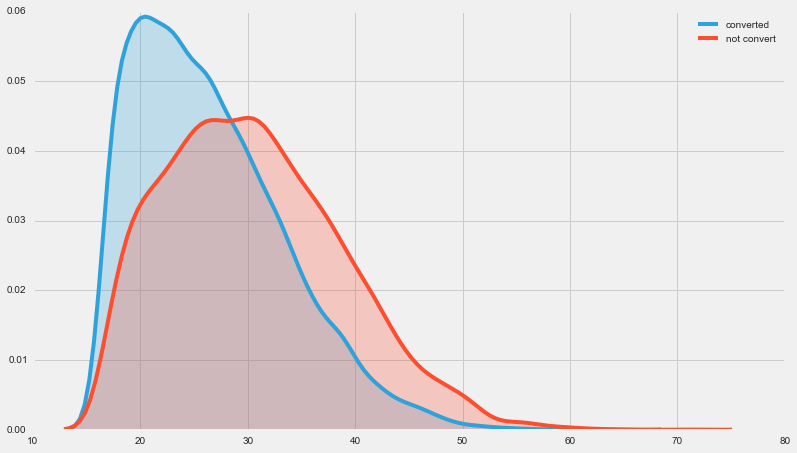

In [132]:
sns.kdeplot(data_1.query('converted==1').age,shade=True, label='converted')
sns.kdeplot(data_1.query('converted==0').age,shade=True, label='not convert')

Younger people are more likely to convert than older people. We see that the conversion rate seems to drop almost linearly and then we see a spike from between 60 and 70 years. Let's investigate further

In [15]:
#data_1[data_1.age>=60].sort('age')
data_1.query('age>=60').sort_values(by='age')

,country,age,new_user,source,total_pages_visited,converted
8362,US,60,0,Seo,12,1
15180,US,60,1,Ads,6,0
15492,US,60,1,Direct,8,0
18300,US,60,1,Seo,5,0
18970,US,60,1,Seo,5,0
16674,US,61,0,Ads,1,0
18813,US,61,1,Seo,9,0
20197,US,62,1,Direct,4,0
748,UK,63,0,Seo,20,1
14214,US,63,0,Seo,1,0


Upon closer examination that spike is a result of the single case of a 65 year old who converted

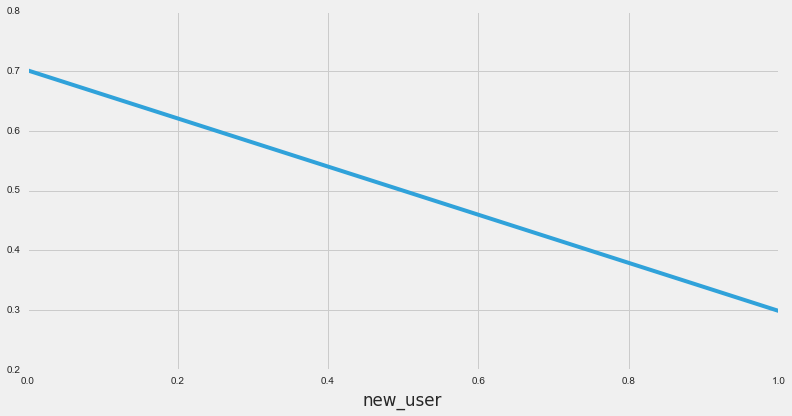

In [54]:
conversion_bynew_user=data_1['converted'].groupby(data_1['new_user'])
conversion_bynew_user.aggregate(np.mean).plot()


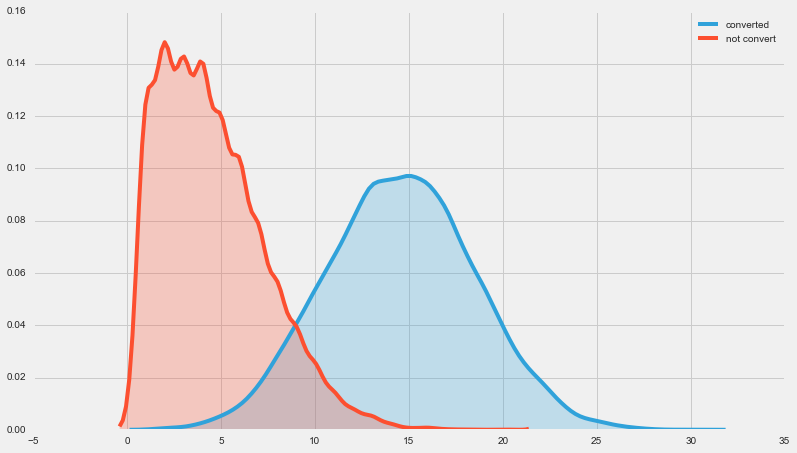

In [137]:
sns.kdeplot(data_1.query('converted==1').total_pages_visited,shade=True, label='converted')
sns.kdeplot(data_1.query('converted==0').total_pages_visited,shade=True, label='not convert')

Old users are better than new users on average

## Model
I will first use a logistic regression model and then see if I can improve the model by using a Random Forest. 

In [17]:
data_country=pd.get_dummies(data_1['country'])
data_source=pd.get_dummies(data_1['source'])
data_1=pd.concat([data_1,data_country], axis=1)
data_1=pd.concat([data_1,data_source], axis=1)

In [18]:
data_1.head()

,country,age,new_user,source,total_pages_visited,converted,China,Germany,UK,US,Ads,Direct,Seo
0,UK,20,1,Direct,11,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,UK,37,1,Ads,15,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,UK,30,0,Seo,15,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,US,32,0,Seo,12,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,UK,29,0,Ads,16,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [19]:
X=data_1[['age', 'new_user', 'total_pages_visited', 'US', 'Germany', 'China', 'Seo','Ads']]
y=data_1['converted']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=33)
#logistic regression
log_model=LogisticRegression()
log_model=log_model.fit(X_train, y_train)
print log_model.score(X_train,y_train)

0.939796051771


In [21]:
log_model.score(X_test,y_test)

0.94176470588235295

In [23]:
log_model.coef_

array([[-0.06917452, -1.76736752,  0.76274465, -0.42856908,  0.10741344,
        -3.64361318,  0.26122959,  0.30660937]])

In [24]:
predicted=log_model.predict(X_test)
print predicted


[0 1 1 ..., 0 1 1]


In [52]:
#generate class probabilities
probs= log_model.predict_proba(X_test)
print probs

[[  9.12884441e-01   8.71155594e-02]
 [  1.91106943e-01   8.08893057e-01]
 [  9.01697250e-04   9.99098303e-01]
 ..., 
 [  9.94129462e-01   5.87053769e-03]
 [  1.04368471e-04   9.99895632e-01]
 [  5.14105865e-04   9.99485894e-01]]


In [53]:
#generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])


0.941764705882
0.986546330745


In [26]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.94411765  0.9377451   0.93529412  0.94460784  0.94362745  0.93480392
  0.92794118  0.94754902  0.94065718  0.9475233 ]
0.940386675514


In [56]:
print metrics.classification_report(y_test,predicted)
#predict the probability of conversion
log_model.predict_proba(np.array([30,0,7,1,0,0,0,1]))



             precision    recall  f1-score   support

          0       0.94      0.94      0.94      2544
          1       0.94      0.94      0.94      2556

avg / total       0.94      0.94      0.94      5100



array([[ 0.6378915,  0.3621085]])